### Direct Search
Likely to be MORDM
1) Initialize Model/ Problem Specification
2) Search Candidate Solutions (based on Ref Scenario)
3) Re-Evaluate Solutions under Uncertainty (Many Scenario)
4) Save Results

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Model, RealParameter,  Scenario, MultiprocessingEvaluator, ScalarOutcome, perform_experiments, ema_logging)
from ema_workbench import Samplers, Policy
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1) Initialize Model

In [2]:
#------------------------- Set Model Parameters
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
nfe = 10000

### 2) Search Candidate Solutions (based on Ref Scenario)
- Run Optimization on Lever Space
- Find Candidate Policies

In [3]:
'''

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 6) as evaluator:
    results1, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1]*len(model.outcomes),
                                              convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
    
results1.to_csv('results/optimization_{}_{}.csv'.format(problem_formulation,nfe))

'''

[MainProcess/INFO] pool started with 6 workers
18277it [38:39,  7.88it/s]                                                     
[MainProcess/INFO] optimization completed, found 5493 solutions
[MainProcess/INFO] terminating pool


In [4]:
# final result data set
results = pd.read_csv("results/optimization_6_10000.csv")
results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,1,1,0,1,8,3,2,...,2.216782e+07,0.001222,0.000000e+00,1.258646e+07,0.000000,0.000000e+00,5.817663e+07,0.000000,151900000.0,49.784147
1,1,1,0,0,1,0,4,2,4,1,...,2.029929e+07,0.004940,2.736980e+06,6.320800e+06,0.000069,0.000000e+00,4.027367e+07,0.000000,205800000.0,1250.782045
2,2,0,0,0,0,0,0,3,1,3,...,2.419803e+07,0.002642,5.600704e+05,7.332080e+06,0.000122,0.000000e+00,4.846370e+07,0.000000,0.0,0.000000
3,3,1,0,1,1,0,3,4,1,1,...,2.029929e+07,0.001860,0.000000e+00,2.038434e+07,0.000000,0.000000e+00,3.667668e+07,0.000000,236500000.0,815.024240
4,4,0,0,1,1,0,1,9,4,1,...,2.029929e+07,0.006058,2.943793e+05,7.332080e+06,0.000023,0.000000e+00,3.667668e+07,0.000000,151900000.0,203.669194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5488,5488,0,1,0,0,0,0,6,6,0,...,0.000000e+00,0.093285,0.000000e+00,7.332080e+06,0.000000,2.759789e+07,0.000000e+00,0.009759,217800000.0,0.000000
5489,5489,0,0,1,0,0,0,3,2,0,...,0.000000e+00,0.040298,1.924638e+06,7.332080e+06,0.000426,1.299325e+08,0.000000e+00,0.046128,30700000.0,0.000000
5490,5490,0,1,1,1,1,0,7,5,1,...,2.029929e+07,0.014409,1.485220e+06,6.320800e+06,0.000309,5.698235e+07,0.000000e+00,0.020236,625800000.0,0.000000
5491,5491,1,0,1,1,0,1,2,4,3,...,2.419803e+07,0.000000,0.000000e+00,1.426165e+07,0.000000,0.000000e+00,4.419351e+07,0.000000,236500000.0,0.000000


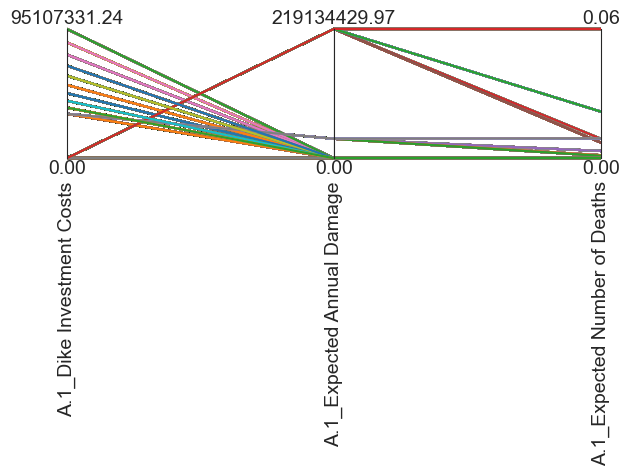

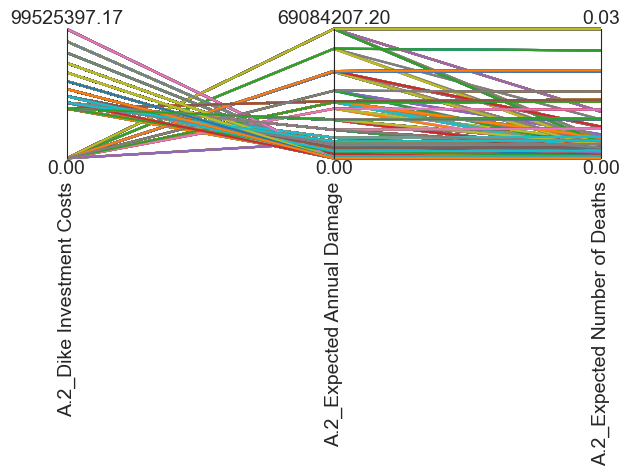

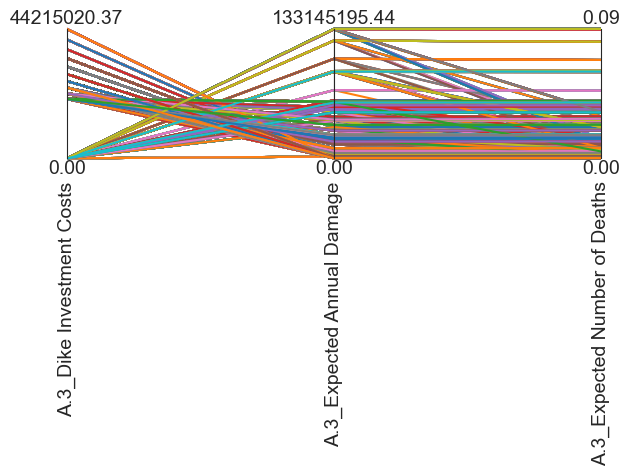

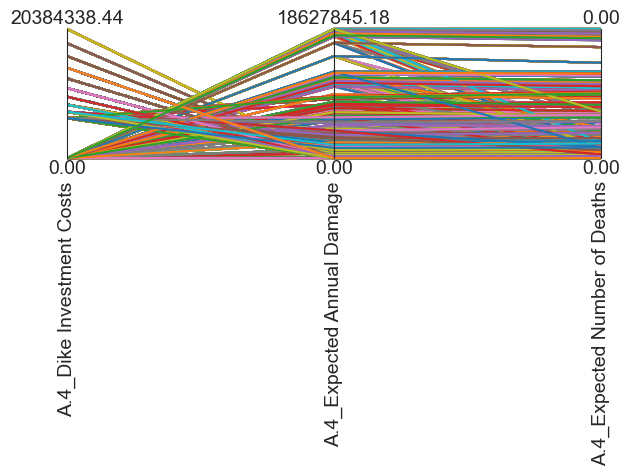

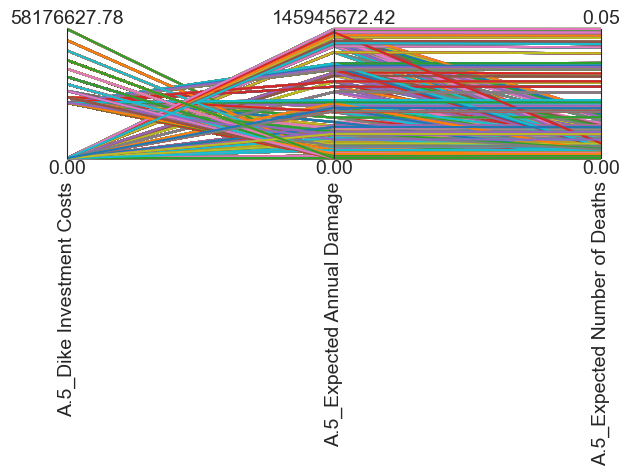

In [5]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = results.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

### 3) Re-Evaluate Solutions under Uncertainty (Few Candidate Policies, Many Scenario)


#### 3a Constrain Conditions

In [6]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
results["Overijssel_Deaths"] = results[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Damages"] = results[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Investment"] = results[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)


results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment
0,0,0,0,1,1,0,1,8,3,2,...,5.817663e+07,0.000000,151900000.0,49.784147,0.001361,5.771094e+06,1.463096e+08,0.000000,0.000000e+00,7.076308e+07
1,1,1,0,0,1,0,4,2,4,1,...,4.027367e+07,0.000000,205800000.0,1250.782045,0.004940,5.812986e+07,1.109131e+08,0.000069,2.736980e+06,4.659447e+07
2,2,0,0,0,0,0,0,3,1,3,...,4.846370e+07,0.000000,0.0,0.000000,0.014164,3.420527e+07,1.047347e+08,0.000122,5.600704e+05,5.579578e+07
3,3,1,0,1,1,0,3,4,1,1,...,3.667668e+07,0.000000,236500000.0,815.024240,0.002784,4.251689e+07,1.063924e+08,0.000000,0.000000e+00,5.706101e+07
4,4,0,0,1,1,0,1,9,4,1,...,3.667668e+07,0.000000,151900000.0,203.669194,0.006058,2.387124e+07,1.589222e+08,0.000023,2.943793e+05,4.400876e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5488,5488,0,1,0,0,0,0,6,6,0,...,0.000000e+00,0.009759,217800000.0,0.000000,0.093285,1.331452e+08,1.267624e+08,0.009759,2.759789e+07,7.332080e+06
5489,5489,0,0,1,0,0,0,3,2,0,...,0.000000e+00,0.046128,30700000.0,0.000000,0.043766,6.650904e+07,8.510992e+07,0.046554,1.318572e+08,7.332080e+06
5490,5490,0,1,1,1,1,0,7,5,1,...,0.000000e+00,0.020236,625800000.0,0.000000,0.014409,2.043834e+07,1.478484e+08,0.020545,5.846757e+07,6.320800e+06
5491,5491,1,0,1,1,0,1,2,4,3,...,4.419351e+07,0.000000,236500000.0,0.000000,0.000000,0.000000e+00,1.148118e+08,0.000000,0.000000e+00,5.845517e+07


In [7]:
#Set threshiold for priority 1, 2 and 3: Deaths, Damages and Investment costs
distribution_threshold_deaths = 0.2
distribution_threshold_damages = 0.2
distribution_threshold_investment = 0.2
#Refine Policies-Dataframe to fit Priority 1 criterion
results2 = results.sort_values("Gelderland_Deaths")
results2 = results.iloc[0:int(len(results2)*distribution_threshold_deaths),:]

#Refine Policies-Dataframe to fit Priority 2 criterion
results3 = results2.sort_values("Gelderland_Damages")
results3 = results3.iloc[0:int(len(results3)*distribution_threshold_damages),:]

#Refine Policies-Dataframe to fit Priority 3 criterion
results4 = results3.sort_values("Gelderland_Investment")
policies = results4.iloc[0:int(len(results4)*distribution_threshold_investment),:]

policies

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment
388,388,1,0,1,0,0,0,0,2,3,...,0.000000e+00,0.050553,115300000.0,0.000000,0.003469,9.062893e+06,6.701645e+07,0.051294,1.449185e+08,7.332080e+06
991,991,1,1,1,0,0,1,0,3,3,...,0.000000e+00,0.018301,333100000.0,1760.621886,0.000141,1.004550e+06,7.204073e+07,0.018622,1.462697e+08,7.332080e+06
536,536,1,1,0,1,1,1,0,3,3,...,0.000000e+00,0.007622,679700000.0,829.058677,0.001791,8.657265e+06,7.204073e+07,0.007847,6.240129e+07,6.320800e+06
961,961,1,0,1,0,0,1,0,4,2,...,0.000000e+00,0.017500,115300000.0,1834.677843,0.002665,1.038500e+07,7.552639e+07,0.018186,1.453757e+08,6.320800e+06
616,616,1,1,1,0,0,2,0,3,5,...,3.337712e+07,0.000000,333100000.0,16.926540,0.000059,1.004550e+06,7.664110e+07,0.000000,0.000000e+00,4.596357e+07
52,52,0,1,0,1,1,4,0,3,5,...,0.000000e+00,0.002579,595100000.0,1829.791073,0.000178,3.806002e+06,7.664110e+07,0.002579,6.024585e+07,1.106877e+07
283,283,0,1,1,0,0,0,0,2,7,...,0.000000e+00,0.050553,248500000.0,0.000000,0.003469,9.062893e+06,7.703998e+07,0.050553,1.415756e+08,1.426165e+07
771,771,0,1,1,0,0,3,0,4,3,...,2.503721e+07,0.003728,248500000.0,2365.738880,0.000000,0.000000e+00,7.755661e+07,0.003961,9.570976e+07,3.135801e+07
342,342,1,1,0,1,1,1,0,3,6,...,4.846370e+07,0.000000,679700000.0,38.636970,0.000533,3.806002e+06,7.924150e+07,0.000000,0.000000e+00,5.579578e+07
30,30,0,1,0,1,1,1,0,4,4,...,4.846370e+07,0.000000,595100000.0,0.000000,0.000000,0.000000e+00,7.976195e+07,0.000000,0.000000e+00,6.105016e+07


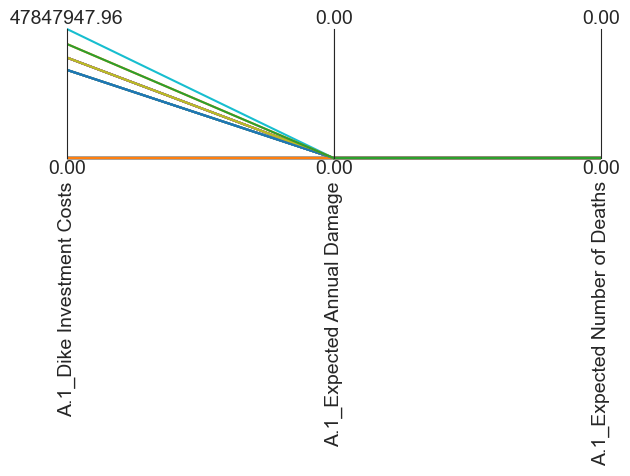

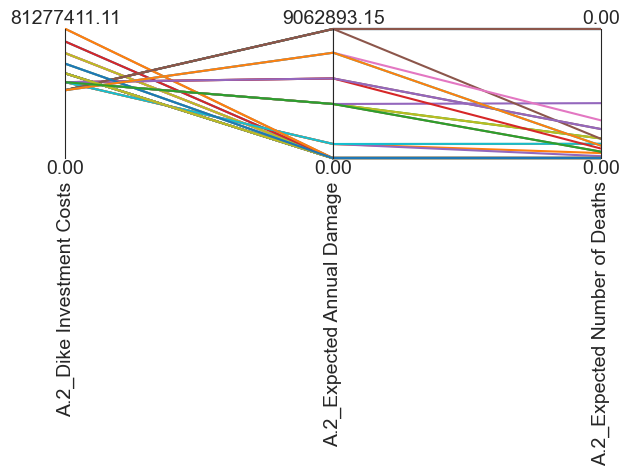

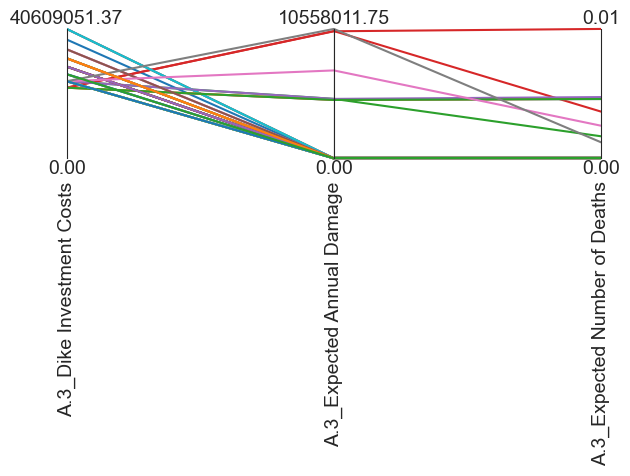

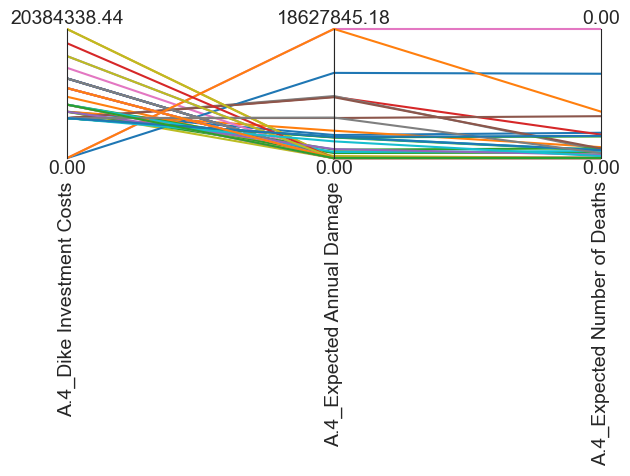

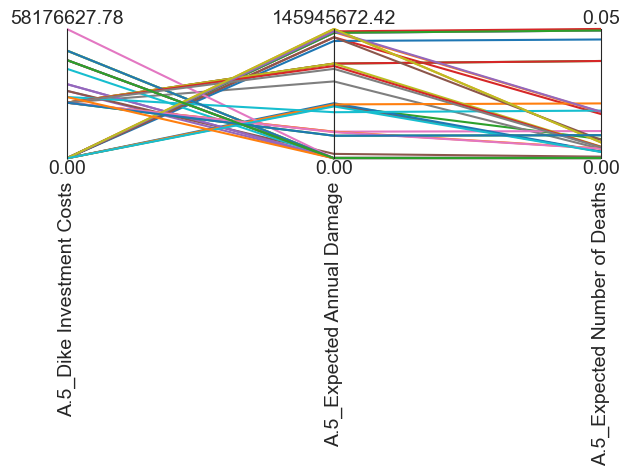

In [8]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = policies.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

#### 3b Robustness Analysis (Run Scenarios)

In [9]:
# Policies are subsequently collected in a list as policy objects
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
    
#Analogous to the polciy class-instances, our scenario are collected in a list of scenario class instances
scenarios = experiments.drop(columns=["policy","model"])
scenario_dict = scenarios.to_dict('index')
list_scenarios = []
for key in scenario_dict.keys():
    list_scenarios.append(Scenario(key,**scenario_dict[key]))

NameError: name 'experiments' is not defined

In [ ]:
n_scenarios = 100
'''

with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2.tar.gz')

'''

In [ ]:
rob_results = load_results ('results/MORDM2.tar.gz')

#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [ ]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
experiments, outcomes = rob_results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

In [ ]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
    paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])

paraxes.legend()

#paraxes.invert_axis('max_P')
plt.show()

##### 3c2 Calculate Regret

In [ ]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
experiments, outcomes = rob_results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

visualize as heatmap

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

In [ ]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

##### 3c3 Scenario Discovery for some conditions (IF NECESSARY)

In [ ]:
'''

from ema_workbench.analysis import prim

x = 
y = 

prim_alg = prim.Prim(x, y, threshold=0.5)
box = prim_alg.find_box()

'''

In [ ]:
#box.inspect_tradeoff()

In [ ]:
#boxno = 2
#box.inspect(boxno)

In [ ]:
#box.select(boxno)